In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [4]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [19]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Исследуем целевую переменную

In [6]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

В целом и без графика понятно распределение целевой переменной. Она принимает всего 2 значения.

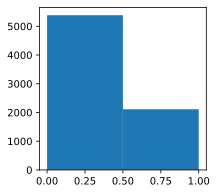

In [8]:
df['Credit Default'].hist(figsize=(3,3), bins=2, grid=False)

### Исследуем признаки

Посчитаем основные статистики по каждому признаку (минимальные, максимальные, средние значения)

In [9]:
train = df.drop('Credit Default', axis = 1)

In [10]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000


In [58]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1f18fcc70>,
      dtype=object)

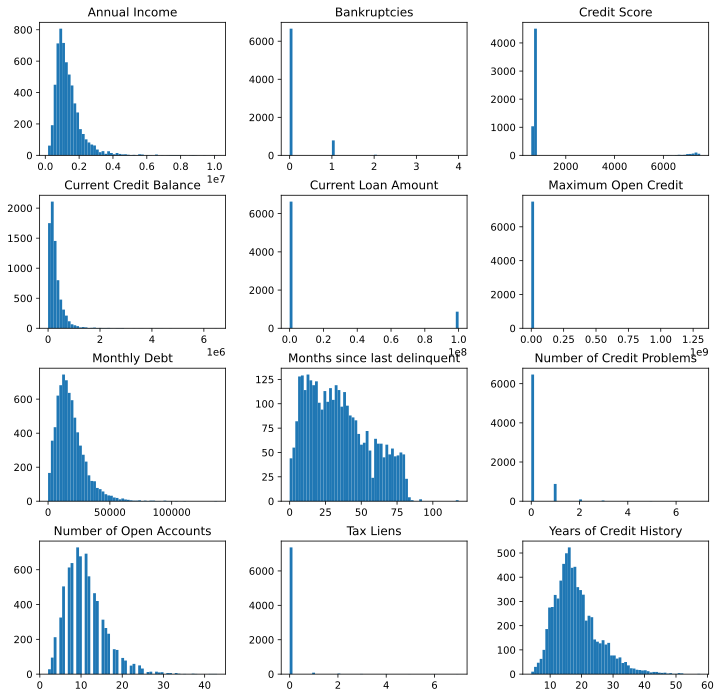

In [11]:
train.hist(figsize=(12,12), bins=60, grid=False)

#### Сравним с распределением на тесте

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1f6d7b400>,
      dtype=object)

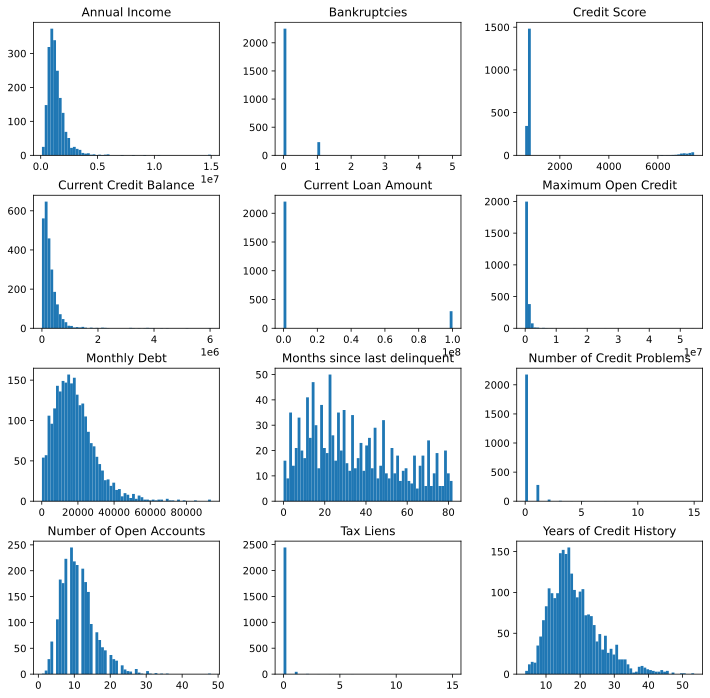

In [23]:
df_test.hist(figsize=(12,12), bins=60, grid=False)

Судя по данным графикам значительные отличия в распределение есть по признакам "Months since last delinquent" и "Maximum Open Credit".
Сравним их детальней.

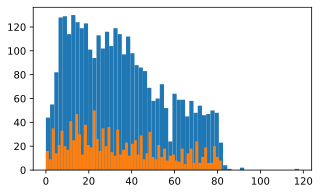

In [29]:
train["Months since last delinquent"].hist(figsize=(5,3), bins=60, grid=False)
df_test["Months since last delinquent"].hist(figsize=(5,3), bins=60, grid=False)

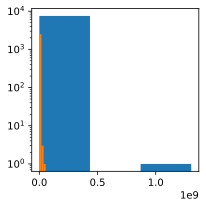

In [48]:
train["Maximum Open Credit"].hist(figsize=(3,3), bins=3, grid=False).set_yscale('log')
df_test["Maximum Open Credit"].hist(figsize=(3,3), bins=3, grid=False).set_yscale('log')

In [ ]:
Похоже в "Maximum Open Credit"  координальные отличие по значениям

#### Построим матрицу корреляции признаков и целевой переменной

In [56]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

CAT_FEATURE_NAMES = ["Home Ownership", "Years in current job", 
                     "Tax Liens, Bankruptcies", "Number of Credit Problems", "Purpose, Term"]

NUM_FEATURE_NAMES = ["Annual Income", "Number of Open Accounts", "Years of Credit History",
                     "Maximum Open Credit", "Months since last delinquent", "Current Loan Amount",
                     "Current Credit Balance", "Monthly Debt", "Credit Score"]

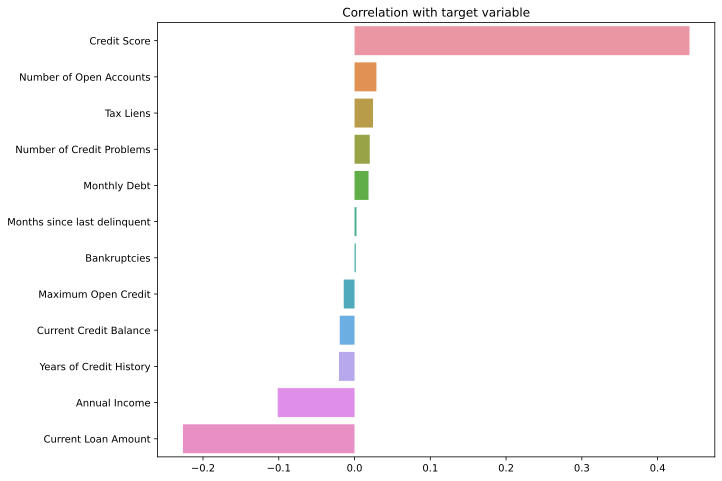

In [16]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

#### Построим матрицу корреляций признаков

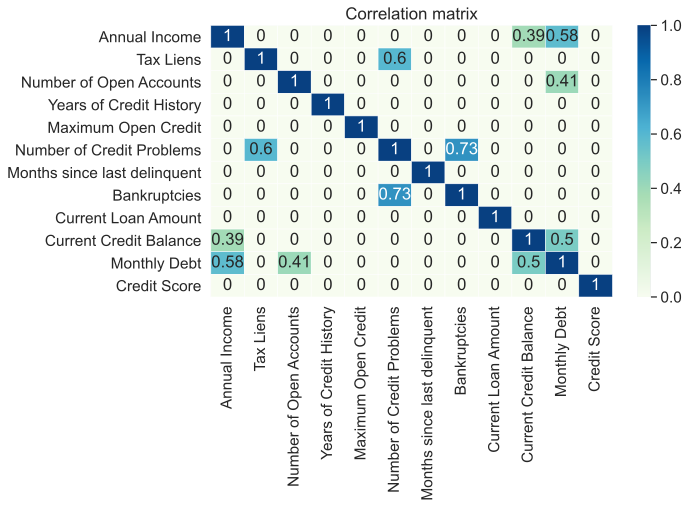

In [53]:
plt.figure(figsize=(9, 5))

sns.set(font_scale=1.4)

corr_matrix = df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Разберемся с каждым из признаков

**Home Ownership** - категориальный признак.

In [79]:
train['Home Ownership'].value_counts()

0    3649
1    3204
2     647
Name: Home Ownership, dtype: int64

In [ ]:
Построим корреляцию с целевой переменной.

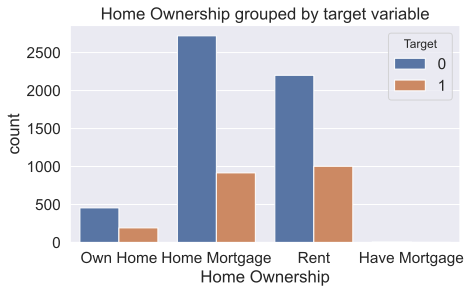

In [64]:
plt.figure(figsize=(7, 4))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=df)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Home Mortgage и Have Mortgage кажется что по сути одно и то же. Чтобы не удалять данные **обеденим эти два признака** в один. Тем более что в Have Mortgage всего 12 значений 

In [76]:
train.loc[train['Home Ownership'] == "Have Mortgage", "Home Ownership"] = "Home Mortgage"

*Заменим значения* на dummy переменные 0,1,2

In [78]:
train['Home Ownership'] = train['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1', 'Own Home':'2'}).astype(int)

**Annual income** - нормальное распределение смещенное влево. Людей с доходом больше 1,6млн не много. Приводить их к среднему наверно не стоит. Введем для таких новую переменную "Rich"

**Years in current job** - категориальный признак

In [81]:
train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

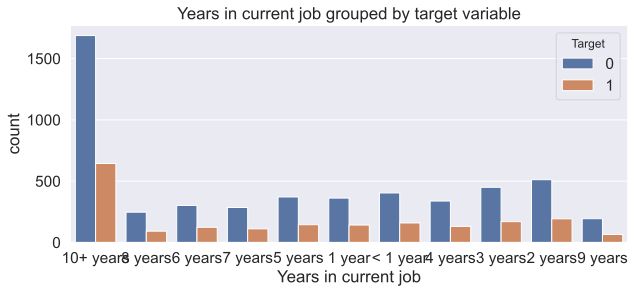

In [84]:
plt.figure(figsize=(10, 4))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Tax Liens** - больше 90% значений лежат на значений "0,0". Предлагаю сделать из этой перменной категориальную и поменять значения отличные от 0 на еденицу 

In [29]:
train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

**Number of Open Accounts** - нормальное распределение немного смещенное влево. Можем заменить на мединные значения выше 25.

**Years of Credit History** - нормальное распределение немного смещенное влево. Я думаю тут прямая корреляция с возрастом человека и можно попроовать создать отдельный признак для тех чья кредитная история больше 40-45 лет. Это явно уже люди пожилые по которым есть повышенные риски не возврата.

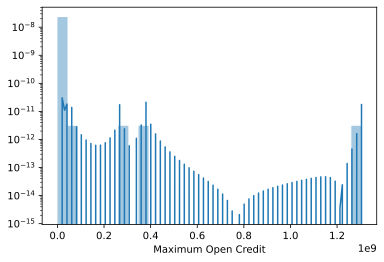

In [47]:
g = sns.distplot(train['Maximum Open Credit'], bins=30)
g.set_yscale('log')

**Maximum Open Credit** - сложно что то сказать по этому графику. Надо будет проверить нули. Если это люди которые не брали кредиты, то сделать для них отдельный категориальный признак. Можно еще посмотреть на корреляцию этого признака с целевой переменной.

In [48]:
train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

**Number of Credit Problems** - Все у кого 2е и больше проблемы можно считать выбросом. Заменим все значения больше 0 на 1. Разделим всех на проблемных и не проблемных

**Months since last delinquent** - достаточно ровное распределние. Всех у кого больше 75 дней просрочки можно заменить на 75% квантиль.